# **Gasoline Pricing, Tax, and Consumptions in the U.S** 
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/00/1st_Cavalry_Division_Patch.svg/150px-1st_Cavalry_Division_Patch.svg.png" width='300px'> 

In [165]:
# ODIN-Project Dependencies 
from odin_eia_db.engine.odin_spark import ODINSpark
from odin_eia_db.utils.odin_secrets_manager import ODINSecretsManager
from odin_eia_db.gasoline_pricing import ODINGasolinePricing
from odin_eia_db.utils.constants import TBL_NAME
from pyspark.sql import functions as f 

from datetime import datetime
import pandas as pd 
import numpy as np 
import pymysql 
import warnings

import matplotlib.pyplot as plt 
import seaborn as sns 

from typing import List, Dict 

plt.style.use('ggplot') 
warnings.filterwarnings('ignore') 

## **Helper Functions** 

In [167]:
@f.udf
def get_month_name(transc_date: str): 
    return pd.to_datetime(transc_date if transc_date else datetime.today().strftime('%Y-%m-%d') ).month_name()

## **ODIN-Resources**

In [113]:
odin_secrets: ODINSecretsManager = ODINSecretsManager()
user,passwd,host,db, _ = list(odin_secrets.get_secrets(secret_name='mysql_develoment').values())
con: 'ODIN-MySQL' = pymysql.connect(user=user, passwd=passwd, host=host, db=db)
odin_eia: ODINGasolinePricing = ODINGasolinePricing()  

## **Gasoline & Diesel for transportation by US state in (US cents/gallon) as of October 2021** 

In [4]:
tax_df: 'DataFrame' = pd.io.html.read_html("https://en.wikipedia.org/wiki/Fuel_taxes_in_the_United_States")[0] 
tax_df['Gasoline tax (¢/gal) (excludes federal tax of 18.4¢/gal)'] = tax_df['Gasoline tax (¢/gal) (excludes federal tax of 18.4¢/gal)'].astype(str).apply(lambda row: row.replace("[9]", "")).astype(float)
tax_df['Notes'] = tax_df['Notes'].replace({np.nan: "N/A"})
tax_df = tax_df.rename({tax_df.columns.tolist()[1]: 'Gasoline tax (¢/gal)'}, axis=1)
tax_df['federal tax of 18.4¢/gal']= [18.4] *tax_df.shape[0]

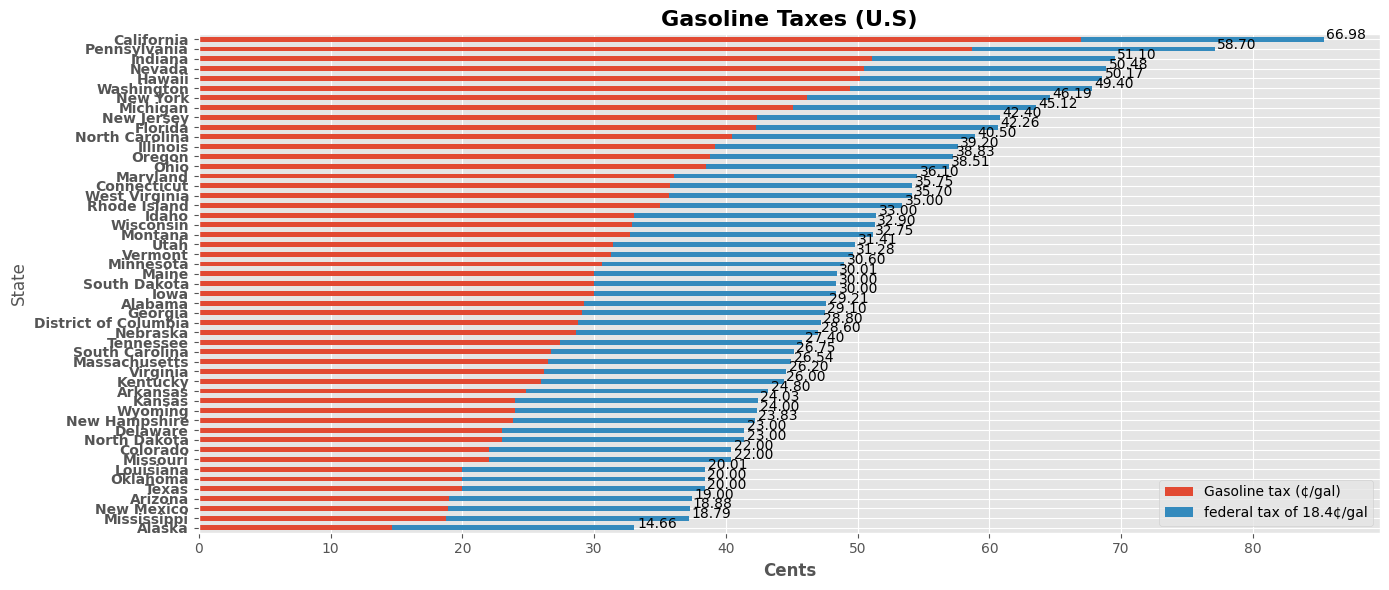

In [67]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot() 
tax_df[tax_df.columns.tolist()[:2] + [ tax_df.columns[-1] ] ].sort_values(by=tax_df.columns.tolist()[1], ascending=True).set_index('State').plot(kind='barh', stacked=True, ax=ax)
ax.set_title("Gasoline Taxes (U.S)", fontweight='bold', fontsize=16)
ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold') 
ax.set_xlabel("Cents", fontweight='bold')

states, taxes = zip(*tax_df[tax_df.columns.tolist()[:2] + [ tax_df.columns[-1] ] ].sort_values(by=tax_df.columns.tolist()[1], ascending=True).set_index('State').apply(lambda row: row[tax_df.columns.tolist()[1]] + row[tax_df.columns.tolist()[-1]] , axis=1).to_dict().items())
for index,tax in enumerate(taxes): 
    ax.annotate(text=f"{tax-18.4:.2f}", xy=(tax + 0.2,index)) 
plt.tight_layout() 

## **Current Gasoline Pricing** 

In [88]:
query: str = """ 
SELECT 
    g.gas_station_name, 
    g.price, 
    g.postedtime, 
    g.state, 
    g.latitude, 
    g.longitude, 
    CONCAT( g.address, ', ', g.city, ', ',  g.state, ', ', g.zip_code  ) AS `store_address`
FROM gasoline_pricing g 
"""
gasoline_pricing: ODINSpark = ODINSpark(app_name="Current Gasoline Pricing").exec_odin_mysql_query(query=query)
gasoline_pricing = gasoline_pricing.dropna(subset=['postedtime'] )
gasoline_pricing = gasoline_pricing.withColumn('price', f.col('price') )

gasoline_pricing.show(5)

DEBUG:odin_eia_db.engine.odin_spark:
        
                  ..`                                 ./sdmds:`                                             
                +dmmds+-`                          -+ymmmmmmmmdo:`                            ./osyyy/`     
              `ommmmmmmmdhso:`                 ./shmmmmmmmmmmmmmmds/.                     ./ohmmmdmdmm/     
              +mmmmmmmmmmmmmmmhy+//:://///++shdmmmmmmmmmmhsdmmmmmmmmmddyso+/::--.-://+syhdmmmmmmmmmmmmh`    
             :dmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmdooymmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm+    
            .hdmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmsooodmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmd.   
            ommmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmh+osoymmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm/   
           :dmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmdooo+oohmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmms   
          `hdmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmdsoo+ososmmmmmmmmmmmmmmmmmmmm

:: loading settings :: url = jar:file:/opt/spark-3.5.1-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ubuntu/.ivy2/cache
The jars for the packages stored in: /home/ubuntu/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
com.amazonaws#aws-java-sdk-bundle added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-679e3221-5bb3-46c5-a77a-9513004a6229;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.3.1 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.901 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
:: resolution report :: resolve 448ms :: artifacts dl 22ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.901 from central in [default]
	org.apache.hadoop#hadoop-aws;3.3.1 from central in [default]
	org.wildfly.openssl#wildfly-openssl;1.0.7.Final from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evi

+--------------------+-----+----------+-----+---------------+-----------------+--------------------+
|    gas_station_name|price|postedtime|state|       latitude|        longitude|       store_address|
+--------------------+-----+----------+-----+---------------+-----------------+--------------------+
| we aim to meet y...| NULL|      NULL| NULL|           NULL|             NULL|                NULL|
|Thrifty's Gas & L...|  0.0|      NULL|   WY|42.063918182672|-104.186841845512|219 W 20th Ave, T...|
|              Conoco|  0.0|      NULL|   WY|44.393108599822|-104.394482374191|20059 W US-14, Su...|
|            Fat Dogs|  0.0|      NULL|   NE|      41.112526|      -101.714325|100 Prospector Dr...|
|           Town Pump|  0.0|      NULL|   MT|47.116710124689|-104.737243650598|73 Hwy 16, Glendi...|
+--------------------+-----+----------+-----+---------------+-----------------+--------------------+
only showing top 5 rows



In [98]:
gasoline_pricing.printSchema() 

root
 |-- gas_station_name: string (nullable = true)
 |-- price: string (nullable = true)
 |-- postedtime: string (nullable = true)
 |-- state: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- store_address: string (nullable = true)



## **Avg Gasoline Pricing (`EIA`)**

In [112]:
ca_df: 'CaliforniaPricing' = gasoline_pricing.filter(f.col('state') == 'CA' ).withColumn('before_tax',  f.round( (f.col('price') - (0.6698 + 0.184 )).alias('before_tax'), 2)  )
ca_df = ca_df.withColumn('transc_date', f.date_format('postedtime', 'yyyy-MM-dd' ) ) 
ca_df = ca_df.withColumn('month_name', get_month_name(f.col('transc_date')) )
ca_df = ca_df.dropna(subset='transc_date')

daily_pricing: List[Dict] = [ item.asDict() for item in ca_df.select('postedtime', 'price', 'before_tax' ).collect() ] 
daily_pricing_df: 'DataFrame' = pd.DataFrame( daily_pricing)
daily_pricing_df = daily_pricing_df.astype(str).query(f"postedtime != 'None' ")
daily_pricing_df['postedtime'] = pd.to_datetime(daily_pricing_df['postedtime'] )
daily_pricing_df['price'] = daily_pricing_df['price'].astype(float) 
daily_pricing_df['before_tax'] = daily_pricing_df['before_tax'].astype(float) 

premium_gasoline_ca: 'DataFrame' = odin_eia.get_conventional_premium_gasoline(state_name='california')
premium_gasoline_ca['period'] = pd.to_datetime(premium_gasoline_ca['period'] ) 

ca_df.show(5) 

+------------------+-----+--------------------+-----+---------------+-----------------+--------------------+----------+
|  gas_station_name|price|          postedtime|state|       latitude|        longitude|       store_address|before_tax|
+------------------+-----+--------------------+-----+---------------+-----------------+--------------------+----------+
|Wintun Mini Market| 4.32|2024-05-05T15:25:...|   CA|       39.25746|       -122.03053|3790 State Hwy 45...|      3.47|
|          Sinclair| 4.49|2024-05-06T11:55:...|   CA|      33.870384|      -117.943363|1101 W Commonweal...|      3.64|
|          Sinclair| 4.59|2024-05-06T13:07:...|   CA|      33.870384|      -117.943363|1101 W Commonweal...|      3.74|
|            Costco| 4.39|2024-05-06T14:26:...|   CA|33.802444959425|-116.388974413276|72800 Dinah Shore...|      3.54|
|Roadrunner Express| 4.43|2024-05-06T15:01:...|   CA|      33.789657|      -116.928135|2214 Lake Park Dr...|      3.58|
+------------------+-----+--------------

## **Distribution of Daily Gasoline Pricing and Average Premium Gasoline Pricing in `California`** 
- Highest State + Federal Tax

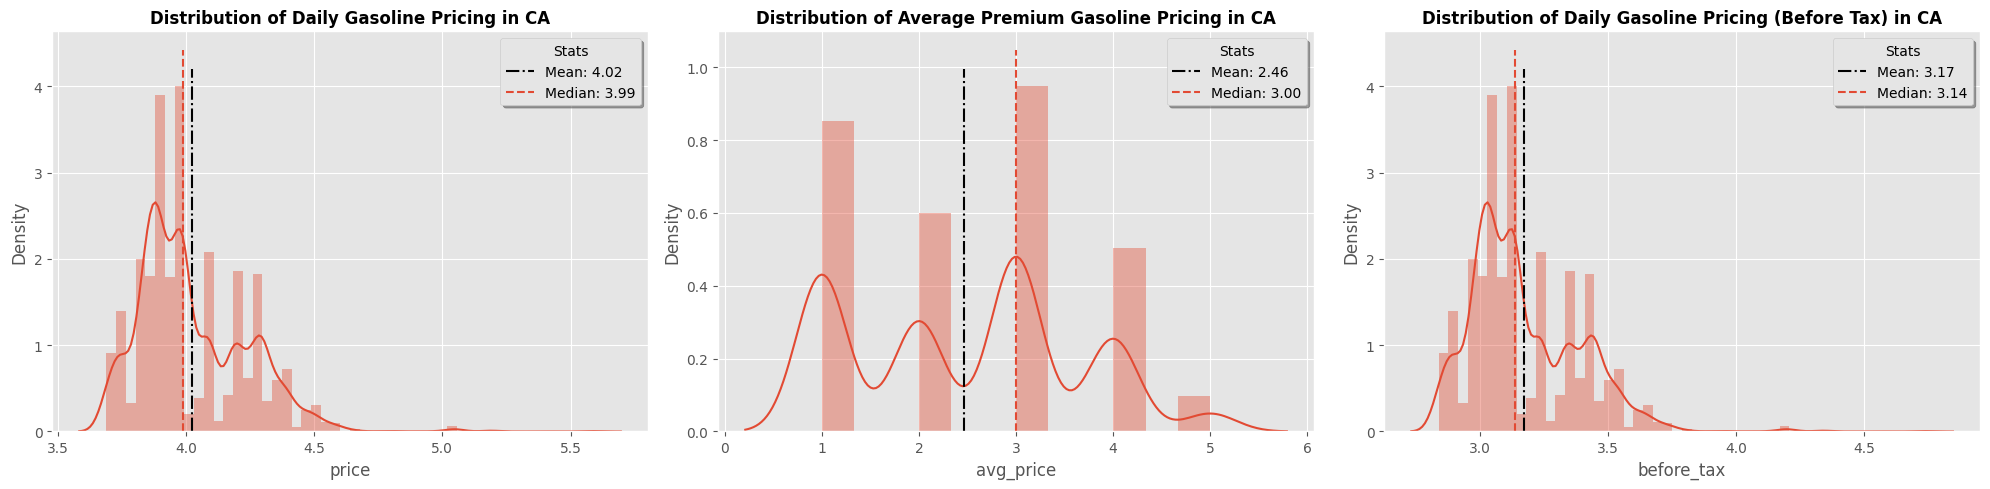

In [152]:
fig = plt.figure(figsize=(20,5))

# Daily Gasoline Pricing 
ax = fig.add_subplot(1,3,1)

mean: float = daily_pricing_df['price'].mean() 
median: float = daily_pricing_df['price'].median() 

sns.distplot( daily_pricing_df['price'],ax=ax )
ax.set_title("Distribution of Daily Gasoline Pricing in CA", fontweight='bold', fontsize=12)
ax.vlines(x=mean, ymin=0.0, ymax=ax.get_ylim()[1], label=f"Mean: {mean:.2f}", linestyles='-.', color='black')
ax.vlines(x=median, ymin=0.0, ymax=ax.get_ylim()[1], label=f"Median: {median:.2f}", linestyles='--')
ax.legend(title="Stats", fancybox=True, shadow=True)

# Average Premium Gasoline Pricing 
ax = fig.add_subplot(1,3,2)
mean: float = premium_gasoline_ca['avg_price'].mean() 
median: float = premium_gasoline_ca['avg_price'].median() 

sns.distplot( premium_gasoline_ca['avg_price'],ax=ax )
ax.set_title("Distribution of Average Premium Gasoline Pricing in CA", fontweight='bold', fontsize=12)
ax.vlines(x=mean, ymin=0.0, ymax=ax.get_ylim()[1], label=f"Mean: {mean:.2f}", linestyles='-.', color='black')
ax.vlines(x=median, ymin=0.0, ymax=ax.get_ylim()[1], label=f"Median: {median:.2f}", linestyles='--')
ax.legend(title="Stats", fancybox=True, shadow=True)

# Before Tax Pricing (Daily) 
ax = fig.add_subplot(1,3,3)
mean: float = daily_pricing_df['before_tax'].mean() 
median: float = daily_pricing_df['before_tax'].median() 

sns.distplot( daily_pricing_df['before_tax'],ax=ax )
ax.set_title("Distribution of Daily Gasoline Pricing (Before Tax) in CA", fontweight='bold', fontsize=12)
ax.vlines(x=mean, ymin=0.0, ymax=ax.get_ylim()[1], label=f"Mean: {mean:.2f}", linestyles='-.', color='black')
ax.vlines(x=median, ymin=0.0, ymax=ax.get_ylim()[1], label=f"Median: {median:.2f}", linestyles='--')
ax.legend(title="Stats", fancybox=True, shadow=True)


plt.tight_layout() 

## **Avg Daily/Weekly Regular & Premium Gasoline Price Trends (Duration: May - June 2024)** 

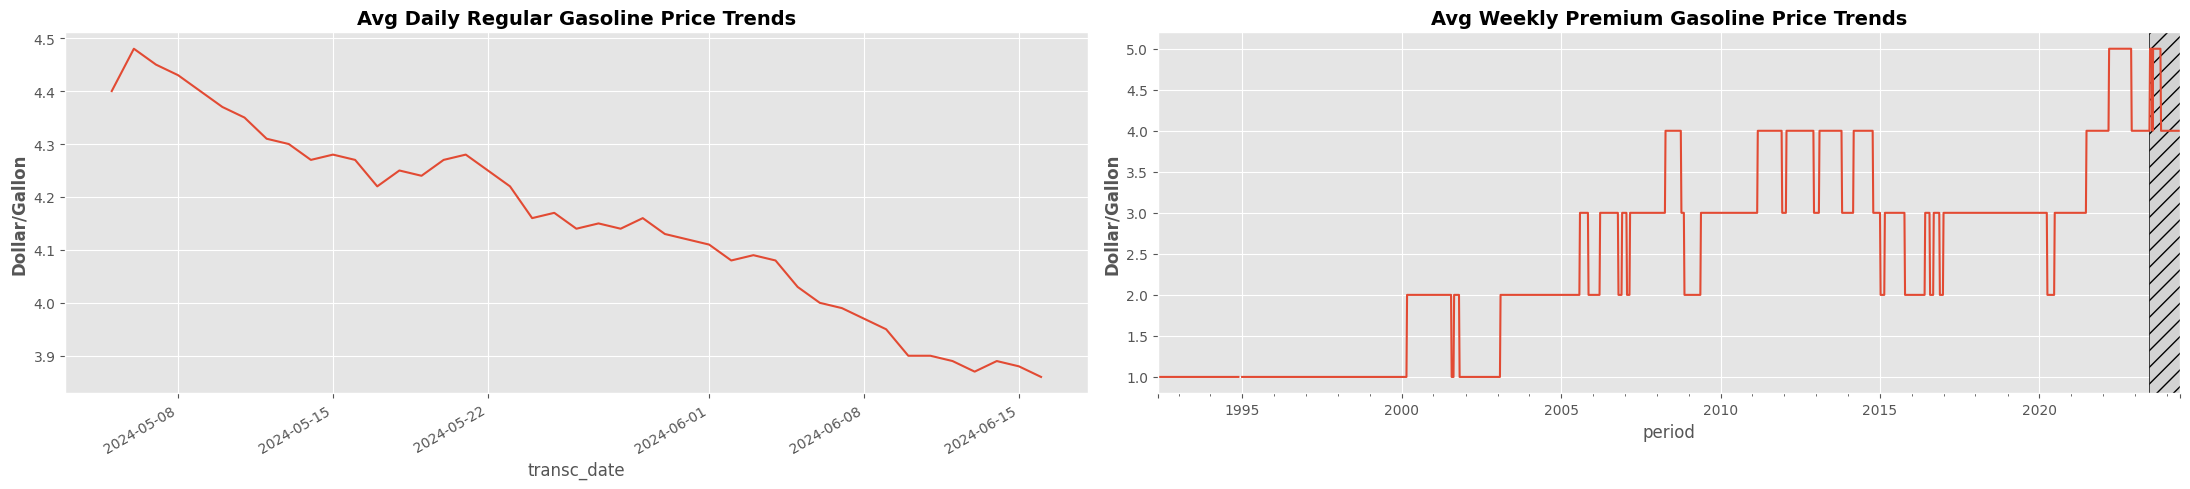

In [203]:
# avg_gasoline_price: 'DataFrame' = pd.DataFrame([ item.asDict() for item in ca_df.groupBy('transc_date').agg(f.round(f.avg('price'), 2).alias('avg_price') ).collect() ]) 
# avg_gasoline_price['transc_date'] = pd.to_datetime(avg_gasoline_price['transc_date'] )

fig = plt.figure(figsize=(22,5))
ax = fig.add_subplot(1,2,1)
avg_gasoline_price.set_index('transc_date')['avg_price'].plot(ax=ax)
ax.set_ylabel("Dollar/Gallon", fontweight='bold')
ax.set_title("Avg Daily Regular Gasoline Price Trends", fontweight='bold', fontsize=14)

ax = fig.add_subplot(1,2,2)
premium_gasoline_ca.set_index('period')['avg_price'].sort_index().plot(ax=ax) 
ax.set_ylabel("Dollar/Gallon", fontweight='bold')
ax.set_title("Avg Weekly Premium Gasoline Price Trends", fontweight='bold', fontsize=14)
ax.axvspan(xmin=2789 , xmax=2840, ec='k', fc='lightgray', hatch='//')

plt.tight_layout() 

## **Top 25 Cheapest Gas in `California`**

In [209]:
ca_df.groupBy(['gas_station_name' ]).agg(f.round( f.avg('price' ), 2).alias('avg_price_by_gas_station_name') ).fillna(0.0).orderBy('avg_price_by_gas_station_name').show(25) 

+--------------------+-----------------------------+
|    gas_station_name|avg_price_by_gas_station_name|
+--------------------+-----------------------------+
|           Mono Wind|                         3.69|
|      Bonfare Market|                         3.82|
|        Platinum Gas|                         3.82|
|              Valero|                         3.83|
|             Fastrip|                         3.88|
|GAS WAR & Empire ...|                         3.88|
|MANN BROS TRUCK STOP|                         3.89|
|      Foxxy Gasoline|                          3.9|
|            Star Gas|                          3.9|
|  Fremont Gas & Food|                         3.92|
|EZ Trip Travel Ce...|                         3.92|
|  Double D Mini Mart|                         3.94|
|           Fuel Mart|                         3.94|
|        American Gas|                         3.97|
|  Diamond Gas & Mart|                         3.97|
|             EZ Trip|                        

In [163]:
ca_df.printSchema() 

root
 |-- gas_station_name: string (nullable = true)
 |-- price: string (nullable = true)
 |-- postedtime: string (nullable = true)
 |-- state: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- store_address: string (nullable = true)
 |-- before_tax: double (nullable = true)
 |-- transc_date: string (nullable = true)
 |-- month_name: string (nullable = true)



## **Join Legacy Pricing & Current Pricing**